# **Настройки + библиотеки**

In [1]:
# библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
%matplotlib inline
# подключение диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# датасет
dataset_path = '/content/drive/My Drive/Bases/WIND_DBASE/dag_2011_2022_final.csv'

# интесесущая станция
st_name = 'Кочубей'

# интересующие признаки данных
col_list = ['datetime',
            't_air', 't_soil', 'P_atm', 'wind_dir', 'wind_speed']

# границы обучающей выборки
train_borders = ['2011-01-01 00:00:00', '2020-12-31 21:00:00']
# границы проверочной выборки
val_borders = ['2021-01-01 00:00:00', '2021-12-31 21:00:00']
# границы тестовой выборки
test_borders = ['2022-01-01 00:00:00', '2022-12-31 21:00:00']

# **Функции**

**Общие функции**

In [3]:
# подготовка датасета (чтение, выделение признаков, нормировка, класс ветра)
# path - путь к исходнику
# st_name - название станции
# col_list - колонки признаков
# mode = 'category' / 'values'
def process_dataset(path, st_name, col_list, norm_0_1=False):
  # читаем данные
  df = pd.read_csv(path)
  # выделяем станцию
  df = df[df.st_name == st_name]
  # выделяем признаки
  df = df[col_list]
  # перевод градусов угла направления ветра в индекс лепестка розы ветров [0..7]
  def conv_360_to_8(val):
    if val >= 360:
      return 0
    else:
      return val // 45
    return res
  def conv_360_to_16(val):
    if val >= 360:
      return 0
    else:
      return val // 22.5
    return res
  df['wind_dir'] = df['wind_dir'].apply(conv_360_to_16).astype('int32')

  # округление температуры воздуха
  df['t_air'] = df['t_air'].astype('int32')
  # приведение температуры воздуха к категориям от 0
  df['t_air'] = df['t_air'] - df['t_air'].min()

  # округление температуры почвы
  df['t_soil'] = df['t_soil'].astype('int32')
  # приведение температуры воздуха к категориям от 0
  df['t_soil'] = df['t_soil'] - df['t_soil'].min()

  # округление атмосферного давления
  df['P_atm'] = df['P_atm'].astype('int32')
  # приведение температуры воздуха к категориям от 0
  df['P_atm'] = df['P_atm'] - df['P_atm'].min()

  # приводим скорости ветра к 3 классам:
  # 0 - от 0 до 3 м/с
  # 1 - от 4 до 7 м/с
  # 2 - от 8 м/с и выше
  def wind_to_class(x):
    if x < 4:
      res = 0
    elif x < 8:
      res = 1
    else:
      res = 2
    return res
  df['wind_class'] = df['wind_speed'].apply(wind_to_class).astype('int32')

  if norm_0_1:
    # нормировка столбцов [0..1]
    for col in col_list[1:]:
      a = df[col].min()
      b = df[col].max()
      df[col] = (df[col] - a)/(b - a)
      df[col] = df[col].astype('float32')

  return df

# нарезка примеров из датафрейма
# df - исходный датафрейм
# days - размер блока данных для X примера (по умолчанию 1 день)
# col_list - колонки c которыми делается выборка
# borders - список из двух значений - границ выборки
def create_samples(df, col_list, borders, days_count=1):
  # выделение данных по границам времени
  rab_df = df[(df.datetime >= borders[0]) & (df.datetime <= borders[1])]
  # размер блока данных
  block_size = days_count * 8
  # начальная позиция текущего смещения в датасете
  pos = 0
  # обнуляем списки примеров...
  samples_x = []
  samples_y = []
  # флаг остановки цикла
  Ex = False
  # нарезка данных в цикле
  while not Ex:
    # если не дошли до конца....
    if pos + block_size < rab_df.shape[0]:
      # формирование вектора X для всех колонок
      x_vec = []
      for col in col_list:
        x_vec.extend(rab_df[col][pos:pos+block_size].to_list())
      # формирование вектора Y
      y_vec = utils.to_categorical(rab_df['wind_class'][pos+block_size:pos+block_size+1].to_list()[0], 3).astype('int')
      # добавление векторов в списки примеров
      samples_x.append(x_vec)
      samples_y.append(y_vec)
    else:
      # прекращение нарезки когда доходим до конца
      Ex = True
    # сдвиг позиции нарезки
    pos += 1 # сдвигаем позицию на 1
  # результат в numpy массивах
  return np.array(samples_x), np.array(samples_y)

# получение весов классов
# df - исходный датафрейм
# borders - список из двух значений - границ выборки
def get_class_weights(df, borders, class_num=3):
  rab_df = df[(df.datetime >= borders[0]) & (df.datetime <= borders[1])]['wind_class']
  class_weights = {}
  for i in range(class_num):
    class_weights[i] = 1.0 / rab_df.value_counts()[i]
  return class_weights

# график обучения
def fit_chart(history):
  # для размера графика...
  def cm_to_inch(value):
    return value/2.54
  plt.figure(figsize=(cm_to_inch(30),cm_to_inch(15)))
  plt.plot([x for x in range(1, len(history.history['accuracy'])+1)],
           history.history['accuracy'],
           label='Точность на обучающем наборе', linewidth=3)
  plt.plot([x for x in range(1, len(history.history['val_accuracy'])+1)],
           history.history['val_accuracy'],
           label='Точность на проверочном наборе', linewidth=3)
  plt.xlabel('Эпоха обучения', fontsize=14)
  plt.ylabel('Точность', fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(True)
  plt.legend(fontsize=14)
  plt.show()

# на основе проверочной или тестовой выборки
# возвращает:
# 1. Точность предсказания
# 2. Список точностей для классов
# 3. Матрицу несоответствий
def get_accuracy_report(model, x, y, class_num=3):
  # предикт
  pred = model.predict(x)
  # массив предсказанных y_pred
  y_pred = []
  for i in range(pred.shape[0]):
    y_pred.append(np.argmax(pred[i]))
  y_pred = np.array(y_pred)
  # numpy массив истинных y_true
  y_true = []
  for i in range(y.shape[0]):
    y_true.append(np.argmax(y[i]))
  y_true = np.array(y_true)
  # матрица несоответсвий
  cm = confusion_matrix(y_true, y_pred)
  res = [None for i in range(class_num)]
  for i in range(class_num):
    res[i] = round(cm[i, i]/(cm[i, :].sum()),3)
  return accuracy_score(y_true, y_pred), res, cm


**Модели**

In [4]:
# только полноcвязный слой
def create_model_dense(x_len, params):

  input = Input((x_len,))

  x = BatchNormalization()(input)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)

# модель со сверточными слоями А
def create_model_conv_a(x_len, params, bs):

  blocks_count = round(x_len / bs)

  input = Input((x_len,))

  xx = [None for i in range(blocks_count)]

  for i in range(blocks_count):

    xx[i] = Reshape((bs, 1))(input[:,i*bs:i*bs+bs])

    #xx[i] = SpatialDropout1D(0.1)(xx[i])
    xx[i] = Conv1D(10, 5, activation=params['activation'])(xx[i])

    xx[i] = Flatten()(xx[i])

  x = concatenate(xx)

  x = BatchNormalization()(x)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)

# модель со сверточными слоями B
def create_model_conv_b(x_len, params):

  input = Input((x_len,))

  x = Reshape((x_len, 1))(input)

  x1 = Conv1D(10, 3, activation=params['activation'])(x)
  x1 = Flatten()(x1)

  x2 = Conv1D(10, 5, activation=params['activation'])(x)
  x2 = Flatten()(x2)

  x3 = Conv1D(10, 7, activation=params['activation'])(x)
  x3 = Flatten()(x3)

  x = concatenate([x1, x2, x3])

  x = BatchNormalization()(x)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)

# модель со сверточными слоями А
def create_model_lstm(x_len, params, bs):

  blocks_count = round(x_len / bs)

  input = Input((x_len,))

  xx = [None for i in range(blocks_count)]

  for i in range(blocks_count):

    xx[i] = Reshape((bs, 1))(input[:,i*bs:i*bs+bs])

    #xx[i] = SpatialDropout1D(0.1)(xx[i])
    xx[i] = LSTM(16, return_sequences=True)(xx[i])

    xx[i] = Flatten()(xx[i])

  x = concatenate(xx)

  x = BatchNormalization()(x)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)



**Компиляция и обучение моделей**

In [5]:
# компиляция модели
def compile_model(model, params):
  model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                loss=['categorical_crossentropy'],
                metrics=['accuracy'])

# обучение модели
def fitting_model(model, params, x_train, y_train, x_val, y_val):
  # колбэк
  checkpoint = ModelCheckpoint('best_model.h5',
                               monitor = 'val_accuracy',
                               verbose = 0,
                               save_best_only=True,
                               mode='max')
  # обучение
  history = model.fit(x_train, y_train,
                      batch_size = params['batch_size'],
                      epochs= params['epochs_count'],
                      validation_data=(x_val, y_val),
                      class_weight=params['class_weight'],
                      verbose=1, callbacks=[checkpoint])
  # загрузка весов
  model.load_weights('best_model.h5')

  return history


# **Чтение и обработка данных, подготовка примеров**

In [6]:
#загрузка и предобработка данных
df = process_dataset(dataset_path, st_name, col_list)
df

,datetime,t_air,t_soil,P_atm,wind_dir,wind_speed,wind_class
2,2011-01-01 00:00:00,33,34,26,15,3,0
6,2011-01-01 03:00:00,33,33,25,15,3,0
9,2011-01-01 06:00:00,33,33,27,13,3,0
14,2011-01-01 09:00:00,32,34,27,13,4,1
17,2011-01-01 12:00:00,31,32,27,13,3,0
...,...,...,...,...,...,...,...
139988,2022-12-31 09:00:00,33,38,38,0,0,0
139993,2022-12-31 12:00:00,36,37,37,6,1,0
139998,2022-12-31 15:00:00,32,28,37,0,0,0
140000,2022-12-31 18:00:00,29,28,42,0,0,0


In [7]:
# количество дней в блоке данных
days_count = 1
# нарезка примеров для обучения
train_x, train_y = create_samples(df, col_list[1:], train_borders, days_count=days_count)
# нарезка примеров для проверки
val_x, val_y = create_samples(df, col_list[1:], val_borders, days_count=days_count)
# нарезка примеров для теста
test_x, test_y = create_samples(df, col_list[1:], test_borders, days_count=days_count)
# размеры выборки
print('Обучающая:', train_x.shape,  train_y.shape)
print('Проверочная:', val_x.shape,  val_y.shape)
print('Тестовая:', test_x.shape,  test_y.shape)
# настройка весов классов для обучающей выборки
class_weight = get_class_weights(df, train_borders)
print(class_weight)

Обучающая: (29216, 40) (29216, 3)
Проверочная: (2912, 40) (2912, 3)
Тестовая: (2912, 40) (2912, 3)
{0: 6.947821857847565e-05, 1: 8.482483671218933e-05, 2: 0.0003287310979618672}


# **ОБУЧЕНИЕ МОДЕЛЕЙ**

**Полносвязные слои**

In [8]:
# параметры обучения
model_params = {'batch_size' : 200,
                'dropout' : 0.3,
                'activation' : 'relu',
                'epochs_count' : 300,
                'learning_rate' : 1e-4,
                'class_weight': class_weight}

In [9]:
# создание модели
model = create_model_dense(train_x.shape[1], model_params)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x,
                        train_y,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
147/147 [==============================] - 7s 9ms/step - loss: 9.5333e-05 - accuracy: 0.4861 - val_loss: 0.9081 - val_accuracy: 0.5635
Epoch 2/300
 19/147 [==>...........................] - ETA: 0s - loss: 8.5255e-05 - accuracy: 0.5942

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 1s 7ms/step - loss: 7.9876e-05 - accuracy: 0.6048 - val_loss: 0.7576 - val_accuracy: 0.6617
Epoch 3/300
147/147 [==============================] - 1s 5ms/step - loss: 7.5369e-05 - accuracy: 0.6326 - val_loss: 0.7341 - val_accuracy: 0.6666
Epoch 4/300
147/147 [==============================] - 1s 5ms/step - loss: 7.3158e-05 - accuracy: 0.6480 - val_loss: 0.7003 - val_accuracy: 0.6854
Epoch 5/300
147/147 [==============================] - 1s 4ms/step - loss: 7.1991e-05 - accuracy: 0.6557 - val_loss: 0.7031 - val_accuracy: 0.6827
Epoch 6/300
147/147 [==============================] - 1s 5ms/step - loss: 7.0810e-05 - accuracy: 0.6658 - val_loss: 0.6909 - val_accuracy: 0.6878
Epoch 7/300
147/147 [==============================] - 1s 5ms/step - loss: 7.0317e-05 - accuracy: 0.6682 - val_loss: 0.6762 - val_accuracy: 0.7016
Epoch 8/300
147/147 [==============================] - 1s 4ms/step - loss: 6.9480e-05 - accuracy: 0.6743 - val_loss: 0.6792 - val_

In [10]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 83.3 %
Точность класса 1: 61.5 %
Точность класса 2: 72.5 %
[[1269  240   14]
 [ 311  651   96]
 [  11   80  240]]
Общая точность: 0.7417582417582418


In [11]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 92.6 %
Точность класса 1: 59.7 %
Точность класса 2: 60.0 %
[[2354  184    4]
 [ 122  209   19]
 [   1    7   12]]
Общая точность: 0.884271978021978


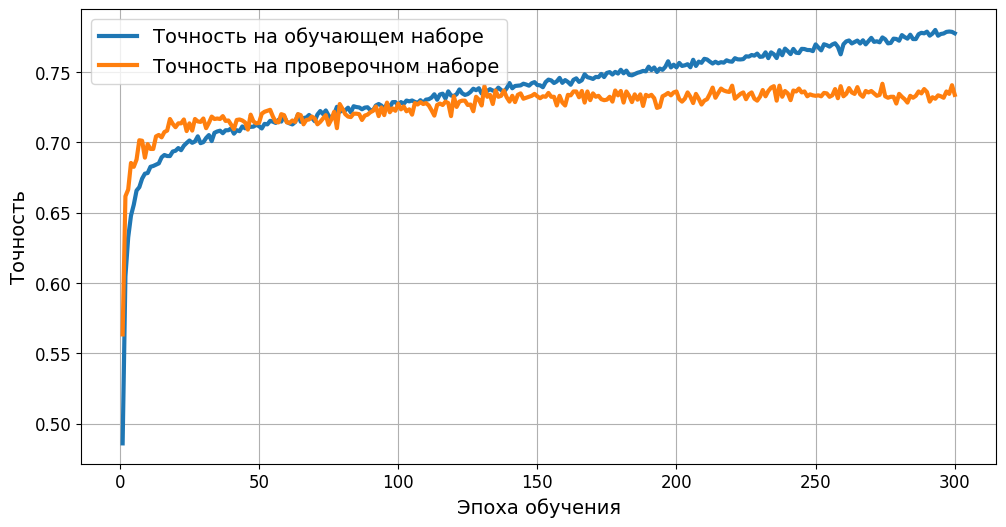

In [12]:
fit_chart(history)

**Сверточные слои А**

In [13]:
block_size = days_count*8

# создание модели
model = create_model_conv_a(train_x.shape[1], model_params, block_size)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x,
                        train_y,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
147/147 [==============================] - 6s 14ms/step - loss: 9.5187e-05 - accuracy: 0.4934 - val_loss: 0.8661 - val_accuracy: 0.5855
Epoch 2/300
 18/147 [==>...........................] - ETA: 0s - loss: 7.9465e-05 - accuracy: 0.5886

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 1s 7ms/step - loss: 7.9648e-05 - accuracy: 0.6039 - val_loss: 0.7762 - val_accuracy: 0.6353
Epoch 3/300
147/147 [==============================] - 1s 9ms/step - loss: 7.5362e-05 - accuracy: 0.6304 - val_loss: 0.7349 - val_accuracy: 0.6542
Epoch 4/300
147/147 [==============================] - 2s 10ms/step - loss: 7.2671e-05 - accuracy: 0.6528 - val_loss: 0.7282 - val_accuracy: 0.6659
Epoch 5/300
147/147 [==============================] - 1s 10ms/step - loss: 7.0980e-05 - accuracy: 0.6626 - val_loss: 0.7020 - val_accuracy: 0.6834
Epoch 6/300
147/147 [==============================] - 2s 11ms/step - loss: 6.9887e-05 - accuracy: 0.6682 - val_loss: 0.6875 - val_accuracy: 0.6872
Epoch 7/300
147/147 [==============================] - 1s 8ms/step - loss: 6.8966e-05 - accuracy: 0.6726 - val_loss: 0.6895 - val_accuracy: 0.6923
Epoch 8/300
147/147 [==============================] - 1s 7ms/step - loss: 6.8131e-05 - accuracy: 0.6801 - val_loss: 0.7011 - v

In [14]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 82.0 %
Точность класса 1: 61.3 %
Точность класса 2: 68.0 %
[[1249  261   13]
 [ 305  649  104]
 [  15   91  225]]
Общая точность: 0.7290521978021978


In [15]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 91.9 %
Точность класса 1: 59.7 %
Точность класса 2: 50.0 %
[[2335  201    6]
 [ 121  209   20]
 [   1    9   10]]
Общая точность: 0.8770604395604396


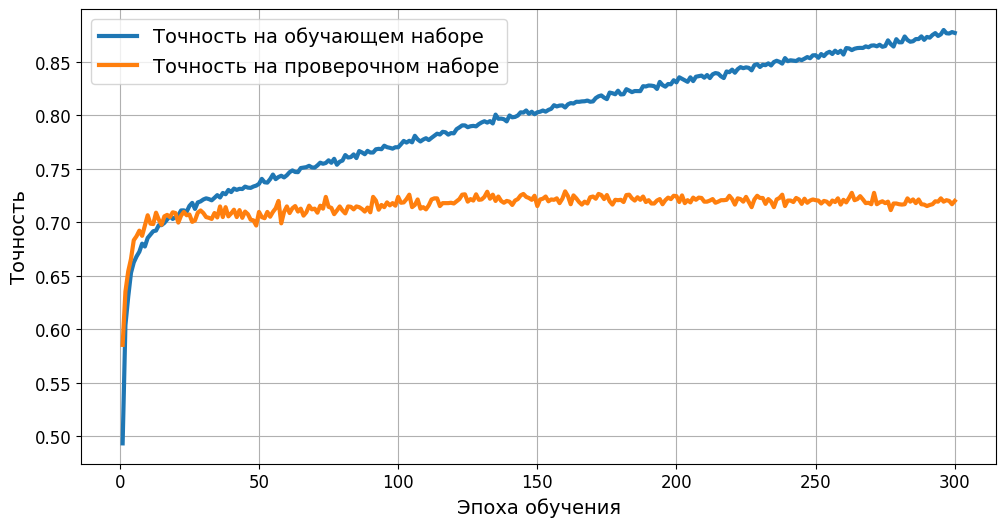

In [16]:
fit_chart(history)

**Сверточные слои B**

In [17]:
# создание модели
model = create_model_conv_b(train_x.shape[1], model_params)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x,
                        train_y,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
147/147 [==============================] - 4s 10ms/step - loss: 9.5150e-05 - accuracy: 0.5238 - val_loss: 0.8937 - val_accuracy: 0.5704
Epoch 2/300
 21/147 [===>..........................] - ETA: 0s - loss: 8.2847e-05 - accuracy: 0.5931

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 1s 6ms/step - loss: 7.9012e-05 - accuracy: 0.6101 - val_loss: 0.7509 - val_accuracy: 0.6542
Epoch 3/300
147/147 [==============================] - 1s 6ms/step - loss: 7.3465e-05 - accuracy: 0.6404 - val_loss: 0.6998 - val_accuracy: 0.6748
Epoch 4/300
147/147 [==============================] - 1s 6ms/step - loss: 7.0129e-05 - accuracy: 0.6629 - val_loss: 0.6822 - val_accuracy: 0.6793
Epoch 5/300
147/147 [==============================] - 1s 6ms/step - loss: 6.8981e-05 - accuracy: 0.6728 - val_loss: 0.6622 - val_accuracy: 0.6971
Epoch 6/300
147/147 [==============================] - 1s 6ms/step - loss: 6.7338e-05 - accuracy: 0.6780 - val_loss: 0.6729 - val_accuracy: 0.6944
Epoch 7/300
147/147 [==============================] - 1s 9ms/step - loss: 6.6686e-05 - accuracy: 0.6828 - val_loss: 0.6543 - val_accuracy: 0.7050
Epoch 8/300
147/147 [==============================] - 1s 9ms/step - loss: 6.5283e-05 - accuracy: 0.6895 - val_loss: 0.6534 - val_

In [18]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 83.4 %
Точность класса 1: 60.2 %
Точность класса 2: 71.6 %
[[1270  231   22]
 [ 313  637  108]
 [  12   82  237]]
Общая точность: 0.7362637362637363


In [19]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 91.9 %
Точность класса 1: 56.6 %
Точность класса 2: 35.0 %
[[2335  203    4]
 [ 134  198   18]
 [   1   12    7]]
Общая точность: 0.8722527472527473


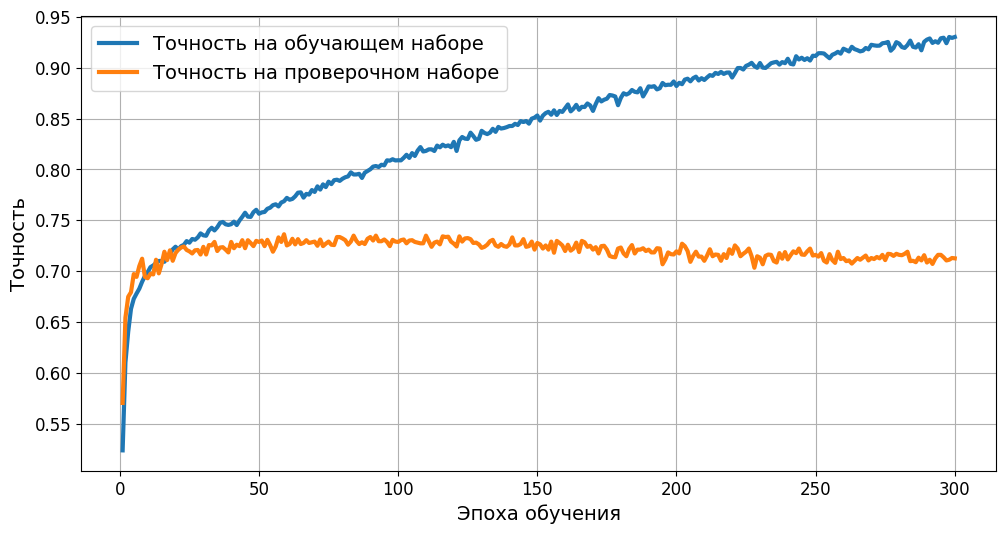

In [20]:
fit_chart(history)

**lstm**

In [21]:
block_size = days_count*8

# создание модели
model = create_model_lstm(train_x.shape[1], model_params, block_size)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x,
                        train_y,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
147/147 [==============================] - 14s 25ms/step - loss: 9.1307e-05 - accuracy: 0.5350 - val_loss: 0.9785 - val_accuracy: 0.6041
Epoch 2/300
  6/147 [>.............................] - ETA: 1s - loss: 8.4274e-05 - accuracy: 0.6183

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 2s 13ms/step - loss: 7.6794e-05 - accuracy: 0.6301 - val_loss: 0.8818 - val_accuracy: 0.6394
Epoch 3/300
147/147 [==============================] - 2s 15ms/step - loss: 7.3422e-05 - accuracy: 0.6477 - val_loss: 0.7693 - val_accuracy: 0.6556
Epoch 4/300
147/147 [==============================] - 3s 18ms/step - loss: 7.1338e-05 - accuracy: 0.6627 - val_loss: 0.7097 - val_accuracy: 0.6799
Epoch 5/300
147/147 [==============================] - 2s 15ms/step - loss: 6.9654e-05 - accuracy: 0.6707 - val_loss: 0.6954 - val_accuracy: 0.6834
Epoch 6/300
147/147 [==============================] - 2s 13ms/step - loss: 6.8886e-05 - accuracy: 0.6770 - val_loss: 0.7061 - val_accuracy: 0.6803
Epoch 7/300
147/147 [==============================] - 2s 12ms/step - loss: 6.8094e-05 - accuracy: 0.6832 - val_loss: 0.7102 - val_accuracy: 0.6810
Epoch 8/300
147/147 [==============================] - 2s 13ms/step - loss: 6.7153e-05 - accuracy: 0.6860 - val_loss: 0.6739

In [22]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 2s 4ms/step
Точность класса 0: 80.8 %
Точность класса 1: 65.1 %
Точность класса 2: 67.1 %
[[1230  276   17]
 [ 283  689   86]
 [  11   98  222]]
Общая точность: 0.7352335164835165


In [23]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 5ms/step
Точность класса 0: 89.7 %
Точность класса 1: 62.0 %
Точность класса 2: 35.0 %
[[2281  254    7]
 [ 117  217   16]
 [   0   13    7]]
Общая точность: 0.8602335164835165


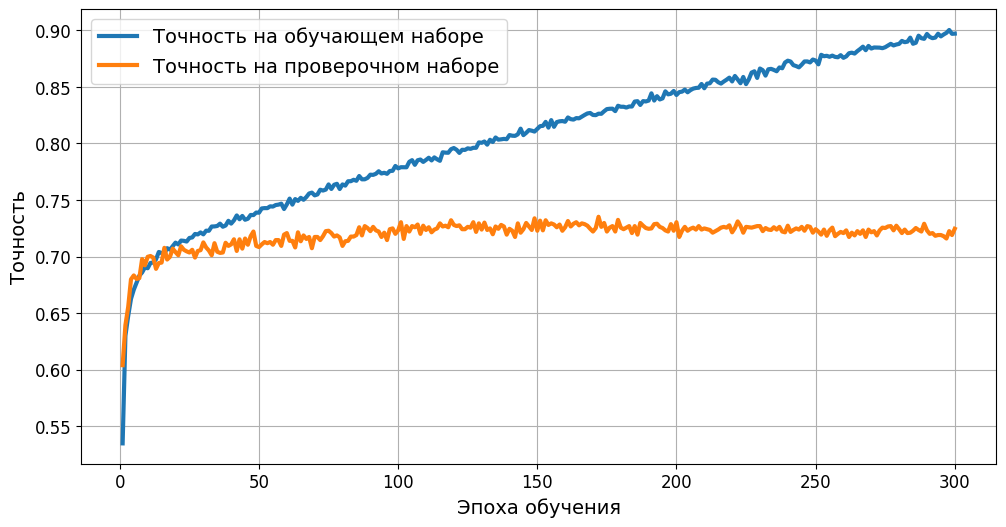

In [24]:
fit_chart(history)